# Introduction

.....

## Imports

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization

import random
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load Data

In [17]:
lines = []

with open('./windows_sim/Training Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurments = []

#This loads the data from the following path 
# ".\windows_sim\Training Data\IMG"
#This path needs to be located in the same folder as this notebook. 

#Load Dataset 1
for line in lines:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path ='./windows_sim/Training Data/IMG/' 
    current_path = current_path + filename[121-35:] #The split did not work well..
    image = cv2.imread(current_path)
    
    
    #The cv2 function makes the rgb coding right for matplotlib, this does not matter for the DL-model
   
    measurment = float(line[3])
    chanse_keep_0 = random.randint(1,10)
    if chanse_keep_0 <=1 and measurment == 0:
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        measurments.append(measurment)
    elif measurment != 0:
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        measurments.append(measurment)
        
#Load Dataset 2
lines2 = []
with open('./windows_sim/Training Data/IMG/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines2.append(line)
        
for line in lines2:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path ='./windows_sim/Training Data/IMG/IMG/' 
    current_path = current_path + filename[len(filename)-len(current_path)+2:] #The split did not work well..
    image = cv2.imread(current_path)
    
   
    #The cv2 function makes the rgb coding right for matplotlib, this does not matter for the DL-model
   
    measurment = float(line[3])
    
    chanse_keep_0 = random.randint(1,10)
    if chanse_keep_0 <=1 and measurment == 0:
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        measurments.append(measurment)
    elif measurment != 0:
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        measurments.append(measurment)
    
    
X_raw = np.array(images)
y_raw = np.array(measurments)
y_raw = y_raw.reshape(len(y_raw),1)

print(y_raw.shape)

#Split into test, train and validation data
#REMOVE THIS!! 

X_train, X_val, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.2, random_state=0)


(3825, 1)


### Understad the data

Number of Training exampels : 3060
Number of Validation exampels : 765

Image Data Shape : (3060, 160, 320, 3)
Label typ : <class 'numpy.ndarray'>
Feature typ : <class 'numpy.ndarray'>


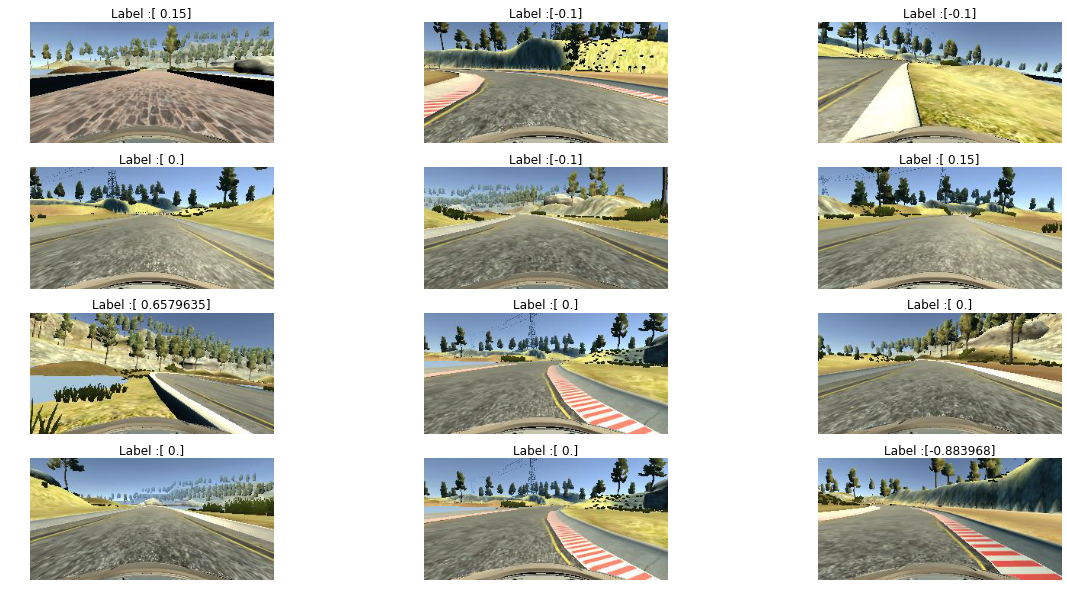

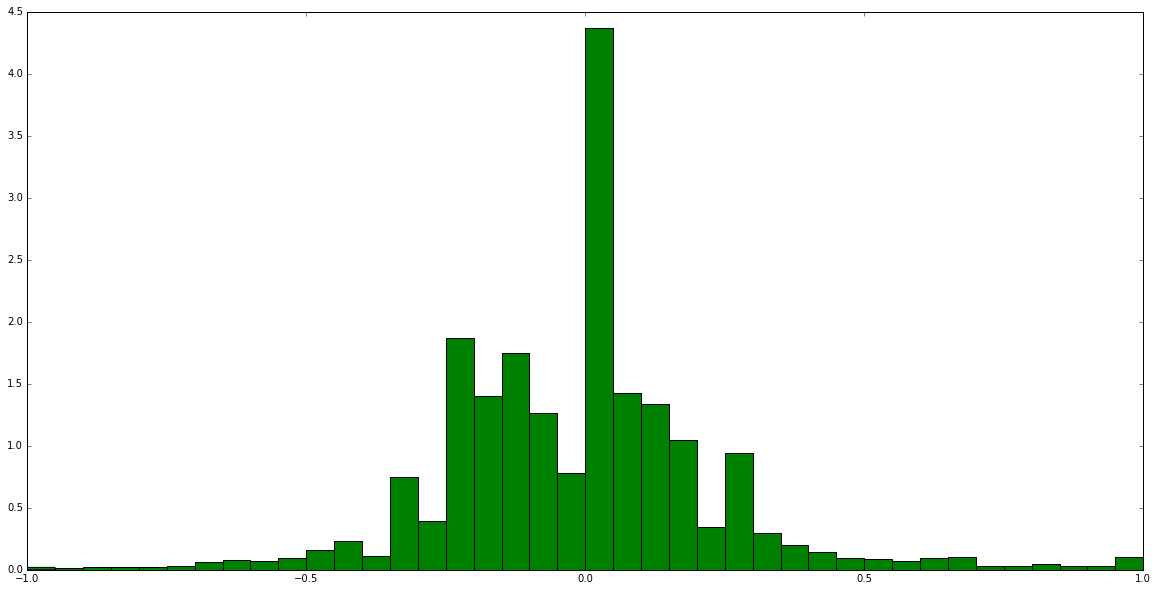

In [18]:
print('Number of Training exampels :', len(X_train))
print('Number of Validation exampels :', len(X_val))


print("")
print('Image Data Shape :', X_train.shape)
print("Label typ :", type(y_train[0]))
print("Feature typ :", type(X_train[0]))

#Show some datapoints (Images with labels)
grid_x, grid_y = 4, 3
f1, cell1 = plt.subplots(grid_x, grid_y, figsize=(20,10))


for i in range(grid_x):
    for j in range(grid_y):
        index = np.random.randint(len(X_train))
        cell1[i,j].imshow(X_train[index])
        cell1[i,j].set_title('Label :{}' .format(y_train[index]))
        cell1[i,j].axis('off')

        
#Shows a histogram over the data, giving understanding of the distrubution
fig2 = plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(y_train,40,  normed=1, facecolor='green')



plt.show()

        


### Analysis 

It seems as there are a lot more exampels of driving straight forward than turning. This migt be a problem during training, as it will lead to the model gaining very high accuracy by only driving forward. So there is a point to augmenting the data to gain a more "normal" distrubution of the dataset. 

### Data augmentation

In [19]:
def augment_img(img):
    '''
    A function to increse the number of images in the dataset. 
    This function performes data augmentation on the images, giving images of different brightness... (more?)
    '''
    
    '''
    add_bright = np.random.randint(-2, 2)
    if add_bright > 0:
        mask = (masked_img[:,:,0] + 0) > 255 
        mask = (masked_img[:,:,1] + 0) > 255 
        mask = (masked_img[:,:,2] + 0) > 255 
    if add_bright <= 0:
        mask = (masked_img[:,:,0] + 0) < 0
        mask = (masked_img[:,:,1] + 0) < 0
        mask = (masked_img[:,:,2] + 0) < 0
        
    masked_img[:,:,:] += np.where(mask, 0, add_bright)  
    '''
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
   

    h, s, v = cv2.split(new_img)
    v += 25
    final_hsv = cv2.merge((h, s, v))

    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img 
    
    
def reduce_size(images, size = (32, 32)):
    '''
    Reduces the size of the images. 
    images is a vector of images
    size is the output size
    returns a np.array with the reduced images
    '''
    new_images = []
    for i in range(len(images)):
        new_images.append(cv2.resize(images[i], size))
        
    
    return np.array(new_images)

In [20]:
X_train_fliped = [] 
y_train_fliped = []

#Flipping images that is turning
for i in range(len(X_train)):
    if(y_train[i] != 0.0 ):
        
        X_train_fliped.append(np.fliplr(X_train[i]))
        y_train_fliped.append(-y_train[i])
        
    X_train_fliped.append((X_train[i]))
    y_train_fliped.append(y_train[i])
    

    
X_train = np.array(X_train_fliped)
y_train = np.array(y_train_fliped)

'''
X_train_reduced = reduce_size(X_train_fliped)
y_train_reduced = y_train_fliped
X_test_reduced = reduce_size(X_test)
X_val_reduced = reduce_size(X_val)    
    
fig1 = plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(y_train_reduced ,50,  normed=1, facecolor='green')


f2, cell2 = plt.subplots(2, 1, figsize=(20,10))

cell2[0].imshow(X_train_reduced[7])
cell2[0].set_title('Label :{}' .format(y_train_reduced[7]))


cell2[1].imshow(X_train_reduced[8])
cell2[1].set_title('Label :{}' .format(y_train_reduced[8]))



plt.show()


#normalize the values
X_train_norm = np.zeros(shape = X_train_reduced.shape, dtype=np.float32)
X_val_norm = np.zeros(shape = X_val_reduced.shape, dtype=np.float32)
X_test_norm = np.zeros(shape = X_test_reduced.shape, dtype=np.float32)

X_train_norm = (X_train_reduced)/255-0.5
X_val_norm =  (X_val_reduced)/255-0.5
X_test_norm =  (X_test_reduced)/255-0.5



#This declaration is done so that it will be easy to follow the process above 
#without needing to change variables in the training
X_train = X_train_norm
y_train = y_train_reduced
X_test = X_test_norm
X_val = X_val_norm  


print(X_train.shape)

'''

"\nX_train_reduced = reduce_size(X_train_fliped)\ny_train_reduced = y_train_fliped\nX_test_reduced = reduce_size(X_test)\nX_val_reduced = reduce_size(X_val)    \n    \nfig1 = plt.figure(figsize=(20,10))\nn, bins, patches = plt.hist(y_train_reduced ,50,  normed=1, facecolor='green')\n\n\nf2, cell2 = plt.subplots(2, 1, figsize=(20,10))\n\ncell2[0].imshow(X_train_reduced[7])\ncell2[0].set_title('Label :{}' .format(y_train_reduced[7]))\n\n\ncell2[1].imshow(X_train_reduced[8])\ncell2[1].set_title('Label :{}' .format(y_train_reduced[8]))\n\n\n\nplt.show()\n\n\n#normalize the values\nX_train_norm = np.zeros(shape = X_train_reduced.shape, dtype=np.float32)\nX_val_norm = np.zeros(shape = X_val_reduced.shape, dtype=np.float32)\nX_test_norm = np.zeros(shape = X_test_reduced.shape, dtype=np.float32)\n\nX_train_norm = (X_train_reduced)/255-0.5\nX_val_norm =  (X_val_reduced)/255-0.5\nX_test_norm =  (X_test_reduced)/255-0.5\n\n\n\n#This declaration is done so that it will be easy to follow the proces

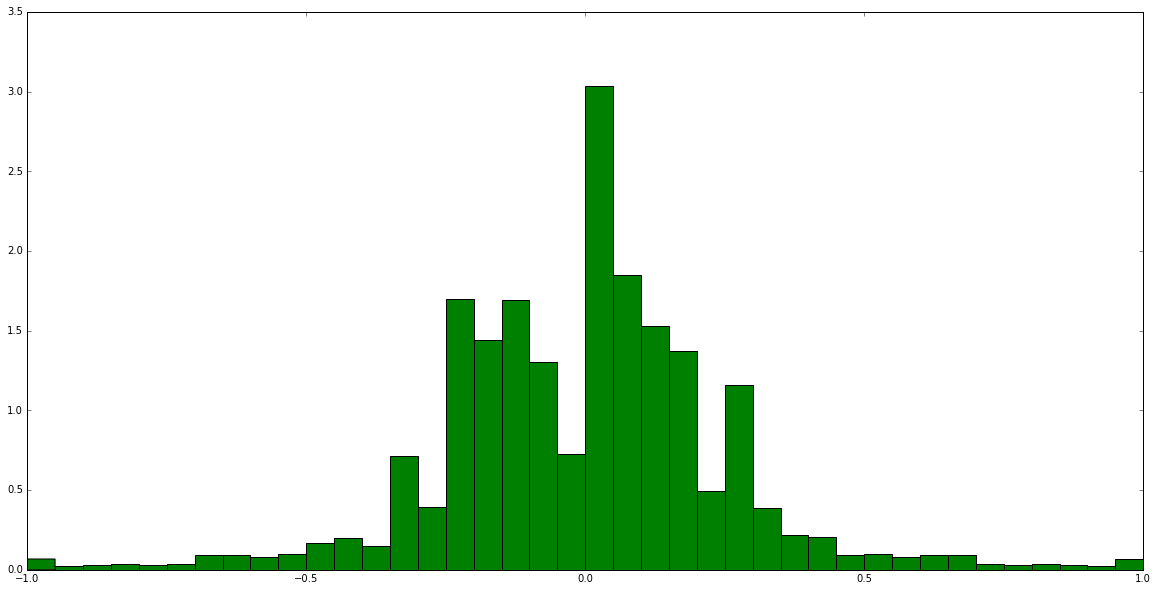

In [21]:
#Shows a histogram over the data, giving understanding of the distrubution
fig2 = plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(y_train,40,  normed=1, facecolor='green')
print(X_train.shape)
plt.show()

## The Network

In [49]:

model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape = (160,320,3)))
model.add(Cropping2D(cropping = ((70,25),(0,0))))


model.add(Conv2D(24, 5, 5, subsample = (2,2), activation='relu'))
model.add(Dropout(0.25))


model.add(Conv2D(36, 5, 5,  subsample = (2,2),activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(48, 5, 5, subsample = (2,2), activation='relu'))

model.add(Conv2D(64, 3, 3, activation='relu'))

model.add(Conv2D(64, 3, 3, activation='relu'))


model.add(Flatten())
model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


## Training

In [51]:
#Hyperparameters: 
rate = 0.001
EPOCHS = 7
BATCH_SIZE = 8
dropout = 0.5

#model.load_weights("model.h5")
model.compile(loss = 'mse', optimizer = 'adam')
history = model.fit(X_train, y_train, shuffle = True, nb_epoch = EPOCHS , validation_data = (X_val, y_val))

model.save('model.h5')


Train on 5602 samples, validate on 765 samples
Epoch 1/7


InternalError: Dst tensor is not initialized.
	 [[Node: Const_1258 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [2112,1164] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Const_1258', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-1a00598151f8>", line 9, in <module>
    history = model.fit(X_train, y_train, shuffle = True, nb_epoch = EPOCHS , validation_data = (X_val, y_val))
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py", line 672, in fit
    initial_epoch=initial_epoch)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 1164, in fit
    self._make_train_function()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 761, in _make_train_function
    self.total_loss)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/optimizers.py", line 423, in get_updates
    ms = [K.zeros(shape) for shape in shapes]
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/optimizers.py", line 423, in <listcomp>
    ms = [K.zeros(shape) for shape in shapes]
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 479, in zeros
    return variable(tf.constant_initializer(0., dtype=tf_dtype)(shape),
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py", line 149, in _initializer
    return constant_op.constant(value, dtype=dtype, shape=shape)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/constant_op.py", line 169, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Dst tensor is not initialized.
	 [[Node: Const_1258 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [2112,1164] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


dict_keys(['val_loss', 'loss'])


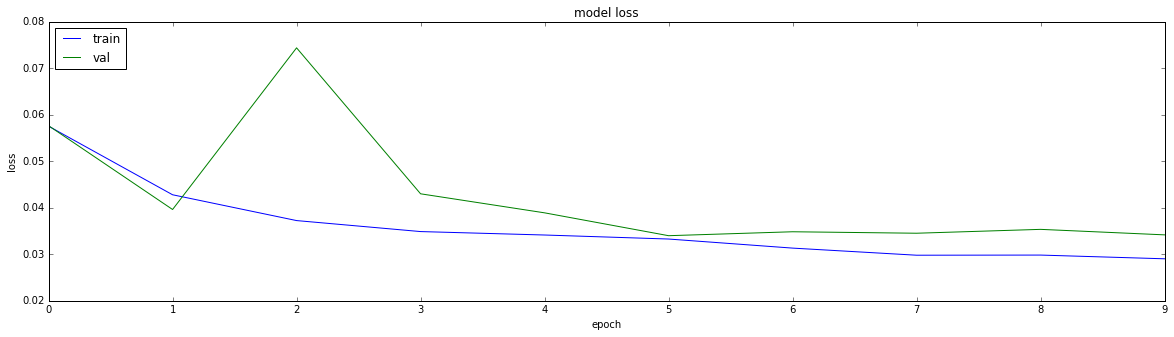

In [41]:

print(history.history.keys())  

plt.figure(figsize=(20,5))  


# summarize history for loss  

plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()  
